#Import Libraries


In [1]:
!pip install tiffile

import time
import os, os.path
import random
import cv2
import glob
import keras
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import tensorflow
import tiffile
from tqdm import tqdm
import pandas as pd
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Import Data

In [ ]:
!unzip /content/drive/MyDrive/tissuetiles.zip -d /content/ 

In [3]:
directory = "newtiles/"
images = []
# imagesDf = pd.DataFrame([])
for filename in tqdm(os.listdir(directory)):
    if (filename.endswith('tif') or filename.endswith('jpeg') or filename.endswith('jpg') or filename.endswith('png')):
        img = tiffile.imread(directory+filename)
        # img = img.flatten()
        images.append(img)

100%|██████████| 18190/18190 [00:37<00:00, 483.21it/s]


In [4]:
images = np.array(images)
SAMPLE_SIZE = 2000
samples = images[np.random.randint(images.shape[0], size=SAMPLE_SIZE), :]
del images
samples = np.array(samples, dtype=np.float32)
samples /= 255
samples.shape

(2000, 256, 256, 3)

#Import Pretrained Models

In [5]:
vgg16_model = tensorflow.keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(256,256,3))

vgg19_model = tensorflow.keras.applications.vgg19.VGG19(include_top=False, weights="imagenet", input_shape=(256,256,3))

resnet50_model = tensorflow.keras.applications.resnet50.ResNet50(include_top=False, weights="imagenet", input_shape=(256,256,3))

94781440/94765736 [==============================] - 1s 0us/step


In [6]:
def covnet_transform(covnet_model, raw_images):
    
    pred = covnet_model.predict(raw_images)
    flat = pred.reshape(raw_images.shape[0], -1)
    return flat

In [ ]:
vgg16_output = covnet_transform(vgg16_model, samples)
print("VGG16 flattened output has {} features".format(vgg16_output.shape[1]))

VGG16 flattened output has 32768 features


In [ ]:
vgg19_output = covnet_transform(vgg19_model, samples)
print("VGG19 flattened output has {} features".format(vgg19_output.shape[1]))

VGG19 flattened output has 32768 features


In [7]:
resnet50_output = covnet_transform(resnet50_model, samples)
print("ResNet50 flattened output has {} features".format(resnet50_output.shape[1]))

ResNet50 flattened output has 131072 features


#PCA on models output


In [ ]:
def create_fit_PCA(data, n_components=None):

    p = PCA(n_components=n_components)
    p.fit(data)
    return p

In [ ]:
import gc
gc.collect()

0

In [ ]:
vgg16_pca = create_fit_PCA(vgg16_output)

In [ ]:
vgg19_pca = create_fit_PCA(vgg19_output)

In [ ]:
# Don't run this cell, It causes memory limit while resnet50 output has 131072 features
# resnet50_pca = create_fit_PCA(resnet50_output)

In [ ]:
def pca_cumsum_plot(pca):
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()

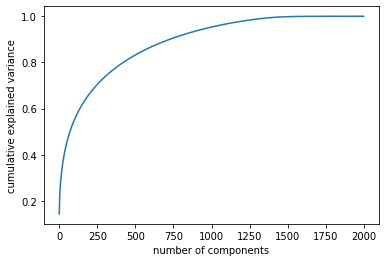

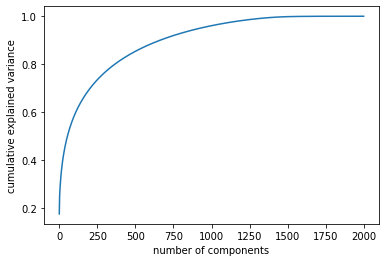

In [ ]:
pca_cumsum_plot(vgg16_pca)
pca_cumsum_plot(vgg19_pca)
# pca_cumsum_plot(resnet50_pca)

In [ ]:
vgg16_output_pca = vgg16_pca.transform(vgg16_output)
vgg19_output_pca = vgg19_pca.transform(vgg19_output)
# resnet50_output_pca = resnet50_pca.transform(resnet50_output)

#T-SNE

In [8]:
def create_fit_TSNE(data, n_components=None):

    t = TSNE(n_components=n_components, method='exact', 
             learning_rate='auto', init='random')
    t.fit(data)
    return t

In [ ]:
vgg16_tsne = create_fit_TSNE(vgg16_output, 50)

In [ ]:
vgg19_tsne = create_fit_TSNE(vgg19_output, 50)

In [ ]:
resnet50_tsne = create_fit_TSNE(resnet50_output, 500)

In [ ]:
vgg16_output_tsne = vgg16_tsne.embedding_
vgg19_output_tsne = vgg19_tsne.embedding_

In [ ]:
resnet50_output_tsne = resnet50_tsne.embedding_

In [ ]:
np.save("/content/drive/MyDrive/zistagene/resnettsne.npy",resnet50_output_tsne)

In [ ]:
vgg16_output_tsne.shape

(2000, 50)

#KMeans & GMM for clustering

In [ ]:
def create_train_kmeans(data, number_of_clusters=6):

    k = KMeans(n_clusters=number_of_clusters)
    start = time.time()
    k.fit(data)
    end = time.time()
    print("Training took {} seconds".format(end-start))
    
    return k

In [ ]:
def create_train_gmm(data, number_of_clusters=6):

    g = GaussianMixture(n_components=number_of_clusters, covariance_type="full")
    start=time.time()
    g.fit(data)
    end=time.time()
    print("Training took {} seconds".format(end-start))
    
    return g
    


In [ ]:
print("KMeans (PCA): ")

print("VGG16")
K_vgg16_pca = create_train_kmeans(vgg16_output_pca)

print("VGG19")
K_vgg19_pca = create_train_kmeans(vgg19_output_pca)


KMeans (PCA): 

VGG16
Training took 2.9381656646728516 seconds

VGG19
Training took 3.1582913398742676 seconds


In [ ]:
print("KMeans (TSNE): ")

print("VGG16")
K_vgg16_tsne = create_train_kmeans(vgg16_output_tsne)

print("VGG19")
K_vgg19_tsne = create_train_kmeans(vgg19_output_tsne)

KMeans (TSNE): 

VGG16
Training took 0.5101790428161621 seconds

VGG19
Training took 0.6626665592193604 seconds


In [ ]:
print("GMM (PCA): ")

print("VGG16")
G_vgg16_pca = create_train_gmm(vgg16_output_pca)

print("VGG19")
G_vgg19_pca = create_train_gmm(vgg19_output_pca)


GMM (PCA): 

VGG16
Training took 30.740419626235962 seconds

VGG19
Training took 26.13747000694275 seconds


In [ ]:
print("GMM (TSNE): ")

print("VGG16")
G_vgg16_tsne = create_train_gmm(vgg16_output_tsne)

print("VGG19")
G_vgg19_tsne = create_train_gmm(vgg19_output_tsne)


GMM (TSNE): 

VGG16
Training took 0.6502118110656738 seconds

VGG19
Training took 0.40059328079223633 seconds


In [ ]:
print("KMeans and GMM on ResNet50 output from TSNE: ")

print("ResNet50")

K_resnet50_tsne = create_train_kmeans(resnet50_output_tsne)

G_resnet50_tsne = create_train_gmm(resnet50_output_tsne)

KMeans and GMM on ResNet50 output from TSNE: 
ResNet50
Training took 0.5743484497070312 seconds
Training took 0.6260745525360107 seconds


In [ ]:

# KMeans with PCA outputs
k_vgg16_pred_pca = K_vgg16_pca.predict(vgg16_output_pca)
k_vgg19_pred_pca = K_vgg19_pca.predict(vgg19_output_pca)
# k_resnet50_pred_pca = K_resnet50_pca.predict(resnet50_output_pca)

# Gaussian Mixture with PCA outputs
# g_resnet50_pred_pca = G_resnet50_pca.predict(resnet50_output_pca)
g_vgg16_pred_pca = G_vgg16_pca.predict(vgg16_output_pca)
g_vgg19_pred_pca = G_vgg19_pca.predict(vgg19_output_pca)

In [ ]:
# KMeans with TSNE outputs
k_vgg16_pred_tsne = K_vgg16_tsne.predict(vgg16_output_tsne)
k_vgg19_pred_tsne = K_vgg19_tsne.predict(vgg19_output_tsne)


# Gaussian Mixture with TSNE outputs
g_vgg16_pred_tsne = G_vgg16_tsne.predict(vgg16_output_tsne)
g_vgg19_pred_tsne = G_vgg19_tsne.predict(vgg19_output_tsne)

In [ ]:
k_resnet50_pred_tsne = K_resnet50_tsne.predict(resnet50_output_tsne)

g_resnet50_pred_tsne = G_resnet50_tsne.predict(resnet50_output_tsne)

In [ ]:
from random import sample
def show_sample(label, labels, data):
    samples = []
    for i in range(len(data)):
        if labels[i] == label:
            samples.append(data[i].reshape(256,256,3))
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 8))
    i = 0
    for s in sample(samples, min(12,len(samples))):
        axes[i//4,i%4].imshow(s)
        i+=1

#PCA Results

In [ ]:
print("KMeans with PCA outputs of VGG16")
for i in range(6):
    print(f"samples with label: {i}")
    show_sample(i, k_vgg16_pred_pca, samples)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print("KMeans with PCA outputs of VGG19")
for i in range(6):
    print(f"samples with label: {i}")
    show_sample(i, k_vgg19_pred_pca, samples)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print("GMM with PCA outputs of VGG16")
for i in range(6):
    print(f"samples with label: {i}")
    show_sample(i, g_vgg16_pred_pca, samples)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print("GMM with PCA outputs of VGG19")
for i in range(6):
    print(f"samples with label: {i}")
    show_sample(i, g_vgg19_pred_pca, samples)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

#TSNE Results


In [ ]:
print("KMeans with TSNE outputs of VGG16")
for i in range(6):
    print(f"samples with label: {i}")
    show_sample(i, k_vgg16_pred_tsne, samples)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print("KMeans with TSNE outputs of VGG19")
for i in range(6):
    print(f"samples with label: {i}")
    show_sample(i, k_vgg19_pred_tsne, samples)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print("GMM with TSNE outputs of VGG16")
for i in range(6):
    print(f"samples with label: {i}")
    show_sample(i, g_vgg16_pred_tsne, samples)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print("GMM with TSNE outputs of VGG19")
for i in range(6):
    print(f"samples with label: {i}")
    show_sample(i, g_vgg19_pred_tsne, samples)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

#ResNet Results


In [ ]:
print("KMeans with TSNE outputs of ResNet50")
for i in range(6):
    print(f"samples with label: {i}")
    show_sample(i, k_resnet50_pred_tsne, samples)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print("GMM with TSNE outputs of ResNet50")
for i in range(6):
    print(f"samples with label: {i}")
    show_sample(i, g_resnet50_pred_tsne, samples)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.